This notebook continues on from '2-mush-obs-images.ipynb' where I downloaded images into classes. This notebook will begin training and testing classification models on the image data. 

## Setting Up the Workspace

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
#!pip install fastai --upgrade -q

In [2]:
from fastai.vision.all import * # for ease of use
from fastai.data.all import *
import os, math, numpy, pandas as pd

In [3]:
# For mounting google drive

#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#datapath = Path('/content/drive/MyDrive/Colab Notebooks/mushroom-proj/data')
datapath = Path.cwd() / 'data'
datapath

Path('/notebooks/storage/mushroom_obs/data')

In [5]:
mushroom_images = Path(datapath/'mushroom-images')

### Model Number 4: Hierarchical/Incremental Learning

The previous 3 models have attempted to classify all 992 species at the same level, but in reality there is at least one natural method of organising the classes hierarchicaly. We can try grouping them by genus first, having one classifier at the genus level, and then a classifier for each genus which will classify species. 

In [9]:
cwd = Path.cwd()

In [10]:
datapath = cwd / Path('data')

In [11]:
genus_level = datapath / Path('mushrooms_by_genus')
genus_level.mkdir(exist_ok=True)

In [21]:
from shutil import copy

In [28]:
i = 0
for im in mushroom_images.rglob('*.jpg'):
    genus_path = genus_level / Path(im.parent.stem.split('-')[0])
    genus_path.mkdir(exist_ok=True)
    species_path = genus_path / Path(im.parent.stem)
    species_path.mkdir(exist_ok=True)
    dest_path = species_path / Path(im.stem + '.jpg')
    copy(im, dest_path)

In [32]:
get_image_files(genus_level)

(#185242) [Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Floccularia/Floccularia-albolanaripes/00000047.jpg'),Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Floccularia/Floccularia-albolanaripes/00000055.jpg'),Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Floccularia/Floccularia-albolanaripes/00000107.jpg'),Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Floccularia/Floccularia-albolanaripes/00000036.jpg'),Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Floccularia/Floccularia-albolanaripes/00000030.jpg'),Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Floccularia/Floccularia-albolanaripes/00000110.jpg'),Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Floccularia/Floccularia-albolanaripes/00000029.jpg'),Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Floccularia/Floccularia-albolanaripes/00000112.jpg'),Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Floccul

### Models to Predict a Mushroom Species from its Image

I'm using an 80:10:10 split for training, validation, and test sets. The test data was set aside manually in notebook 3, and I will use the FastAI Datablock API for training and validation splits. By using a random seed, the validation set used will also be identical across the different models.  

In [12]:
# get further 11.1 % of training set as 10 % test set
valid_pct = 0.1111 # percentage to take from training to make overall test set 10%

In [13]:
def y_func(x):
    parent = Path(x.parent.parent)
    sub_dirs = [x for x in parent.iterdir() if x.is_dir()]
    if len(sub_dirs) > 1:
        return x.parent.parent.stem
    else:
        return x.parent.stem

In [14]:
# function to process filenames (Path objects) into class labels

mushroom_db = DataBlock(blocks = (ImageBlock, CategoryBlock), # inputs are images, outputs are categoriesb
                   get_items = get_image_files,   # get images from folder names
                   get_y = y_func,          # get labels by processing filename
                   splitter = RandomSplitter(valid_pct=valid_pct, seed=0),
                   item_tfms = Resize(224),       # resize all images to 224 x 224
                   batch_tfms = aug_transforms()) # augment images to improve generalisation
mushroom_dl = mushroom_db.dataloaders(genus_level)


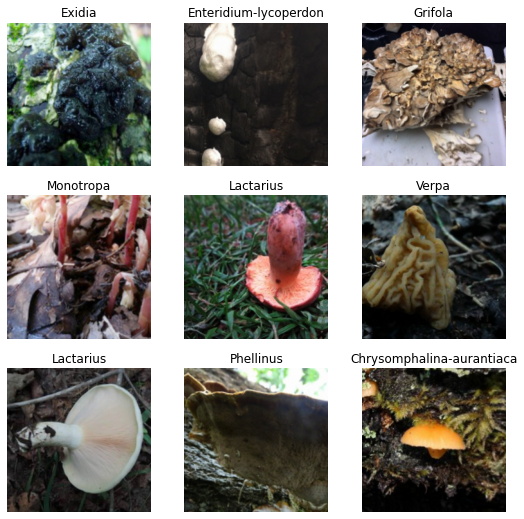

In [12]:
mushroom_dl.show_batch(max_n=9)

In [13]:
mushroom_dl.c

362

So we've gone from 992 down to 332 classes by grouping by genus; if there is only one species then we still classify at the species level. 

## Training resnet34 at the Genus Level

In [15]:
learn = cnn_learner(mushroom_dl, resnet34, metrics=accuracy)

I'm going to use the SaveModelCallback class of FastAI which will save the best model based on validation loss; model with minimum validation loss across all epochs. The fine_tune method will also automatically adjust the learning rate during training. This way I can leave it to train without monitoring the results every epoch. 

In [15]:
learn.fine_tune(14, freeze_epochs=6, cbs=SaveModelCallback(monitor='valid_loss', fname='genus-resnet34'))

epoch,train_loss,valid_loss,accuracy,time
0,4.255114,3.405604,0.292274,10:16
1,3.193285,2.664845,0.378863,10:16
2,2.913845,2.407678,0.428037,10:15
3,2.804263,2.311579,0.441302,10:17
4,2.680950,2.208608,0.462634,10:14
5,2.574264,2.115462,0.484402,10:21


Better model found at epoch 0 with valid_loss value: 3.405604362487793.
Better model found at epoch 1 with valid_loss value: 2.6648454666137695.
Better model found at epoch 2 with valid_loss value: 2.40767765045166.
Better model found at epoch 3 with valid_loss value: 2.3115787506103516.
Better model found at epoch 4 with valid_loss value: 2.2086081504821777.
Better model found at epoch 5 with valid_loss value: 2.115461826324463.


/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


epoch,train_loss,valid_loss,accuracy,time
0,2.151143,1.793247,0.553790,13:12
1,1.995504,1.691413,0.574538,13:13
2,1.930535,1.653938,0.581293,13:14
3,1.777347,1.639927,0.587658,13:13
4,1.729990,1.544351,0.611516,13:12
5,1.519374,1.460602,0.631778,13:11
6,1.354521,1.392071,0.649125,13:14
7,1.259716,1.337135,0.663363,13:14
8,1.090139,1.271224,0.684257,13:14
9,0.937814,1.233244,0.696453,13:15


Better model found at epoch 0 with valid_loss value: 1.7932469844818115.
Better model found at epoch 1 with valid_loss value: 1.6914132833480835.
Better model found at epoch 2 with valid_loss value: 1.6539382934570312.
Better model found at epoch 3 with valid_loss value: 1.6399266719818115.
Better model found at epoch 4 with valid_loss value: 1.544350504875183.
Better model found at epoch 5 with valid_loss value: 1.460601806640625.
Better model found at epoch 6 with valid_loss value: 1.3920705318450928.
Better model found at epoch 7 with valid_loss value: 1.3371351957321167.
Better model found at epoch 8 with valid_loss value: 1.2712244987487793.
Better model found at epoch 9 with valid_loss value: 1.2332440614700317.
Better model found at epoch 10 with valid_loss value: 1.219713807106018.
Better model found at epoch 11 with valid_loss value: 1.2183294296264648.
Better model found at epoch 12 with valid_loss value: 1.204953670501709.
Better model found at epoch 13 with valid_loss value

In [16]:
learn.load('genus-resnet34')

/opt/conda/envs/fastai/lib/python3.8/site-packages/fastai/learner.py:54: UserWarning: Saved filed doesn't contain an optimizer state.
  elif with_opt: warn("Saved filed doesn't contain an optimizer state.")


In [17]:
learn.export('models/genus-resnet34.pkl')

### Traning resnet18 for the within-genus models

Now we have a trained genus classifier, we can train all the species classifiers for every genus containing at least 2 species. 

In [18]:
a = [f for f in genus_level.iterdir() if f.is_dir()]

In [19]:
genus_mods = []
for g in a:
    b = len([f for f in g.iterdir() if g.is_dir()])
    if b > 1:
        genus_mods.append(g)
genus_mods

[Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Cladonia'),
 Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Agrocybe'),
 Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Sarcoscypha'),
 Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Hypholoma'),
 Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Calostoma'),
 Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Leptonia'),
 Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Lobaria'),
 Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Sparassis'),
 Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Stereum'),
 Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Phellinus'),
 Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Clitocybe'),
 Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Xanthomendoza'),
 Path('/notebooks/storage/mushroom_obs/data/mushrooms_by_genus/Marasmius'),
 Path('/noteb

In [20]:
genus_models = Path('genus')

I'll use the same callback to facilitate automated training of all 146 within-genus classifiers. 

In [18]:
%%capture # hides cell output as we trained 146 models...
for g in genus_mods:
    mushroom_db = DataBlock(blocks = (ImageBlock, CategoryBlock), # inputs are images, outputs are categoriesb
                   get_items = get_image_files,   # get images from folder names
                   get_y = parent_label,          # get labels by processing filename
                   splitter = RandomSplitter(valid_pct=valid_pct, seed=0),
                   item_tfms = Resize(224),       # resize all images to 224 x 224
                   batch_tfms = aug_transforms()) # augment images to improve generalisation
    mushroom_dl = mushroom_db.dataloaders(g)
    model_path = genus_models / Path(g.stem)
    learn = cnn_learner(mushroom_dl, resnet18, metrics=accuracy)
    learn.fine_tune(4, freeze_epochs=6, cbs=SaveModelCallback(monitor='valid_loss', fname=model_path))
    learn.load(model_path)
    export_path = Path('models') / Path(str(model_path) + '_EXPORT.pkl')
    learn.export(export_path)
    


Now we have a genus model predicting across 332 genuses; 146 of these genuses contain one or more species so we now have 146 smaller classifiers for each of these genuses.

So we have tried a few different models and the best so far has been resnet34 using transfer learning. 